In [1]:
import trimesh
import numpy as np
import matplotlib.pyplot as plt
stl_filename = r"C:\Users\Emman\Desktop\JE\Ortho\STL-Segmentation\OrthoCAD_Export_43495989\43495989_shell_occlusion_l.stl"
mesh=trimesh.load(stl_filename)

In [2]:
#mesh.show()

In [2]:
import stltovoxel
import numpy as np
import matplotlib.pyplot as plt
input=stl_filename
output=stl_filename[:-3]+"npy"
stltovoxel.convert_file(input, output, voxel_size=0.2)

Processing layer 0/160
Processing layer 1/160
Processing layer 2/160
Processing layer 3/160
Processing layer 4/160
Processing layer 5/160
Processing layer 6/160
Processing layer 7/160
Processing layer 8/160
Processing layer 9/160
Processing layer 10/160
Processing layer 11/160
Processing layer 12/160
Processing layer 13/160
Processing layer 14/160
Processing layer 15/160
Processing layer 16/160
Processing layer 17/160
Processing layer 18/160
Processing layer 19/160
Processing layer 20/160
Processing layer 21/160
Processing layer 22/160
Processing layer 23/160
Processing layer 24/160
Processing layer 25/160
Processing layer 26/160
Processing layer 27/160
Processing layer 28/160
Processing layer 29/160
Processing layer 30/160
Processing layer 31/160
Processing layer 32/160
Processing layer 33/160
Processing layer 34/160
Processing layer 35/160
Processing layer 36/160
Processing layer 37/160
Processing layer 38/160
Processing layer 39/160
Processing layer 40/160
Processing layer 41/160
Pr

In [3]:
voxel=np.load(stl_filename[:-3]+"npy")

In [4]:
voxel2=voxel[voxel[:,2]<30]
voxel2=voxel2[voxel2[:,2]>25]
voxel2=np.unique(voxel2,axis=0)
len(voxel),len(voxel2)

(8461377, 331189)

In [5]:
z_slice=[]
for z in np.unique(voxel2[:,2]):
    z_slice.append(voxel[voxel[:,2]==z][:,:-1])

In [6]:
def getCluster(data,label,label_number):
    center=[]
    for i in range(len(data)):
        if label[i]==label_number:
            center.append(data[i])
    return np.array(center),np.mean(center,axis=0)

def getAllClustersCenters(data,clustering):
    centers=[]
    for i in np.unique(clustering.labels_):
        _,mean_=getCluster(data,clustering.labels_,i)
        centers.append(mean_)
    return centers

In [ ]:
from shapely import hausdorff_distance
from shapely import MultiPoint
from tqdm import tqdm
from scipy.spatial.distance import cdist
list_distance=[]
def distance(res,res_1):
    return hausdorff_distance(MultiPoint(res),MultiPoint(res_1))

def joinClusters(X,kmeans,X_1,kmeans_1):
    for i in range(len(np.unique(kmeans.labels_))):
        res=getCluster(X,kmeans.labels_,i)[0]
        distance_list=[]
        for j in range(len(np.unique(kmeans_1.labels_))):
            res_1=getCluster(X_1,kmeans_1.labels_,j)[0]
            dist=distance(res,res_1)
            if dist!=dist:
                distance_list.append(10_000)
            else:
                distance_list.append(dist)
        list_distance.append(distance_list)
    matrix_2=[np.argmin(elem) for elem in list_distance]
    new_labels=[matrix_2[label] for label in kmeans.labels_]
    return new_labels


def add_clusters(X,kmean,dist_max=9):
    center_2=list(kmeans.cluster_centers_).copy()
    for i in np.unique(kmean.labels_):
        res=getCluster(X,kmean.labels_,i)[0]
        dist=cdist(res,[kmean.cluster_centers_[i]],metric='cityblock')
        test=res[np.where(dist>10)[0]]
        if len(test>0):
            me=np.mean(test,axis=0)
            center_2.append(me)
    kmean = KMeans(n_clusters=len(center_2),random_state=0, init=center_2,n_init="auto").fit(X)
    center_2=list(center_2)
    for i in np.unique(kmean.labels_):
        res=getCluster(X,kmean.labels_,i)[0]
        dist=cdist(res,[kmean.cluster_centers_[i]],metric='cityblock')
        test=res[np.where(dist>dist_max)[0]]
        if len(test>0):
            me=np.mean(test,axis=0)
            center_2.append(me)
    center_2=np.array(center_2)
    kmean = KMeans(n_clusters=len(center_2),random_state=0, init=center_2,n_init="auto").fit(X)
    return kmean

from scipy.spatial.distance import squareform
def getCloseClusters(kmeans):
    test=np.array(np.where((squareform(pdist(kmeans.cluster_centers_))<6)*(squareform(pdist(kmeans.cluster_centers_))!=0)))
    res=[]
    for x in test.T:
        if x not in np.array(res) and [x[1],x[0]] not in np.array(res):
            res.append(x)
    res=np.array(res)
    return res

def joinClusters2(kmeans):
    idx_close=getCloseClusters(kmeans)
    res=[]
    done=[]
    centers=kmeans.cluster_centers_
    for i in range(len(centers)):
        if i not in idx_close:
            res.append(centers[i])
        elif i not in done:
            center_one=centers[idx_close[np.where(idx_close==i)[0][0]][0]]
            center_two=centers[idx_close[np.where(idx_close==i)[0][0]][1]]
            res.append((center_one+center_two)/2)
            done.append(idx_close[np.where(idx_close==i)[0][0]][0])
            done.append(idx_close[np.where(idx_close==i)[0][0]][1])
    return np.array(res)

In [19]:
from tqdm import tqdm
X = z_slice[-1]
kmeans_init = SpectralClustering(n_clusters=8).fit(X)
centers=getAllClustersCenters(X,kmeans_init)
list_kmeans=[kmeans_init]
list_centers=[centers]
X_1=X
kmeans_1=kmeans
for i in tqdm(range(2,25)):
    X=z_slice[-i]
    n_clusters=len(list_centers[i-2])
    kmeans = KMeans(n_clusters=n_clusters, random_state=0,init=list_centers[i-2],n_init="auto").fit(X)
    kmean___=add_clusters(X,kmeans,dist_max=8)
    list_centers.append(getAllClustersCenters(X,kmean___))
    list_kmeans.append(kmean___)
    X_1=X
    kmeans_1=kmeans
    
test=[]
X_1=z_slice[-2]
kmeans_1=list_kmeans[1]
for i in tqdm(range(3,24)):
    X=z_slice[-i]
    kmean=list_kmeans[i]
    test.append(joinClusters(X,kmean,X_1,kmeans_1))
    X_1=X
    kmeans_1=kmeans
    

c:\Users\Emman\anaconda3\envs\ortho\lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
 13%|█▎        | 3/23 [00:00<00:00, 24.71it/s]

8
10
10
11
11


 26%|██▌       | 6/23 [00:00<00:00, 19.00it/s]

13
13
13


 35%|███▍      | 8/23 [00:00<00:01, 12.71it/s]

14
17


 43%|████▎     | 10/23 [00:00<00:01,  9.50it/s]

17
18


 52%|█████▏    | 12/23 [00:01<00:01,  7.76it/s]

19


 57%|█████▋    | 13/23 [00:01<00:01,  6.88it/s]

21


 61%|██████    | 14/23 [00:01<00:01,  5.83it/s]

21


 65%|██████▌   | 15/23 [00:01<00:01,  5.19it/s]

22


 70%|██████▉   | 16/23 [00:02<00:01,  4.73it/s]

22


 74%|███████▍  | 17/23 [00:02<00:01,  4.16it/s]

22


 78%|███████▊  | 18/23 [00:02<00:01,  3.59it/s]

22


 83%|████████▎ | 19/23 [00:03<00:01,  3.25it/s]

22


 87%|████████▋ | 20/23 [00:03<00:00,  3.08it/s]

23


 91%|█████████▏| 21/23 [00:04<00:00,  2.99it/s]

23


 96%|█████████▌| 22/23 [00:04<00:00,  2.93it/s]

23


  5%|▍         | 1/22 [00:01<00:36,  1.72s/it]c:\Users\Emman\anaconda3\envs\ortho\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Emman\anaconda3\envs\ortho\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 95%|█████████▌| 21/22 [06:08<00:17, 17.57s/it]


IndexError: list index out of range

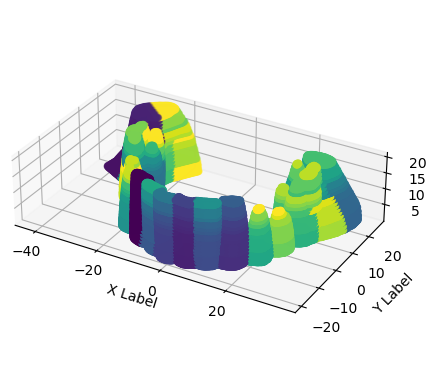

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(1,len(test)):
    ax.scatter(z_slice[i][:,0],z_slice[i][:,1],i,c=list_kmeans[-i].labels_)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_aspect('equal')
plt.show()

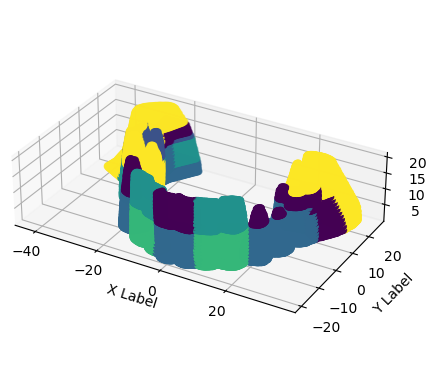

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(1,len(test)):
    ax.scatter(z_slice[i][:,0],z_slice[i][:,1],i,c=test[-i])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_aspect('equal')
plt.show()

In [29]:
from voxelfuse.voxel_model import VoxelModel
from voxelfuse.mesh import Mesh
from voxelfuse.primitives import generateMaterials

model = VoxelModel(voxel)#, generateMaterials(4))  #4 is aluminium.
mesh = Mesh.fromVoxelModel(model)
mesh.export('mesh.stl')

IndexError: tuple index out of range

In [51]:
import open3d as o3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(voxel)
o3d.visualization.draw_geometries([pcd])

In [53]:
pcd.estimate_normals()

# estimate radius for rolling ball
distances = pcd.compute_nearest_neighbor_distance()
avg_dist = np.mean(distances)
radius = 1.5 * avg_dist   

mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
           pcd,
           o3d.utility.DoubleVector([radius, radius * 2]))

# create the triangular mesh with the vertices and faces from open3d
tri_mesh = trimesh.Trimesh(np.asarray(mesh.vertices), np.asarray(mesh.triangles),
                          vertex_normals=np.asarray(mesh.vertex_normals),vertex_colors = np.asarray(mesh.vertex_colors) )

trimesh.convex.is_convex(tri_mesh)

False

In [43]:

#trimesh.exchange.export.export_mesh(tri_mesh, 'outputfile.stl')

array([[ -4.47749378, -26.27422714,   0.2012603 ],
       [ -4.27700914, -26.27422714,   0.2012603 ],
       [ -4.07652449, -26.27422714,   0.2012603 ],
       ...,
       [-26.73128952,  19.90151862,  31.79912665],
       [-26.53080487,  19.90151862,  31.79912665],
       [-26.53080487,  20.10228273,  31.79912665]])

In [46]:
np.array([voxel[:,0],voxel[:,1],voxel[:,2]])

IndexError: tuple index out of range

In [42]:
,np.array(sponge).shape

(3, 3, 3)

In [36]:
voxel.T.shape

(3, 8461377)

Number of Labels:  21


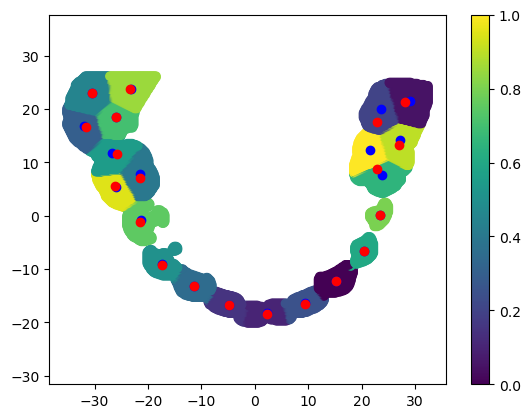

In [340]:
# from sklearn.cluster import KMeans,SpectralClustering
# i=15
# X = z_slice[-i-1]
# X_1=z_slice[-i]
# kmeans=list_kmeans[i]
# kmeans_1=list_kmeans[i-1]
# centers=np.array(getAllClustersCenters(z_slice[-i],kmeans_1))
# print("Number of Labels: ",len(np.unique(kmeans.labels_)))
# plt.scatter(X[:,0],X[:,1],c=kmeans.labels_)
# plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='b')
# plt.scatter(centers[:,0],centers[:,1],c='r')
# plt.axis('equal')
# plt.colorbar()

# #kmeans = SpectralClustering(n_clusters=14).fit(X)
# print("Number of Labels: ",len(np.unique(kmeans.labels_)))
# plt.scatter(X[:,0],X[:,1],c=kmeans.labels_)
# plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='r')
# plt.colorbar()

# X=z_slice[-1]
# kmeans = SpectralClustering(n_clusters=8).fit(X)
# print("Number of Labels: ",len(np.unique(kmeans.labels_)))
# plt.scatter(X[:,0],X[:,1],c=kmeans.labels_)
# plt.colorbar()

Number of Labels:  10


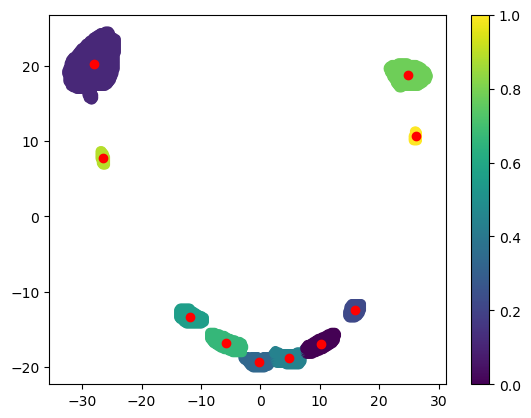

In [42]:
# from scipy.spatial.distance import cdist
# i=1
# X = z_slice[-i-1]
# #center_2=np.array(getAllClustersCenters(z_slice[-i],kmeans_1)).copy()Zz
# kmean=list_kmeans[i]
# center_2=list(kmeans.cluster_centers_).copy()
# for i in np.unique(kmean.labels_):
#     res=getCluster(X,kmean.labels_,i)[0]
#     dist=cdist(res,[kmean.cluster_centers_[i]],metric='cityblock')
#     test=res[np.where(dist>10)[0]]
#     if len(test>0):
#         me=np.mean(test,axis=0)
#         center_2.append(me)
# kmean = KMeans(n_clusters=len(center_2),random_state=0, init=center_2,n_init="auto").fit(X)
# center_2=list(center_2)
# for i in np.unique(kmean.labels_):
#     res=getCluster(X,kmean.labels_,i)[0]
#     dist=cdist(res,[kmean.cluster_centers_[i]],metric='cityblock')
#     test=res[np.where(dist>9)[0]]
#     if len(test>0):
#         me=np.mean(test,axis=0)
#         center_2.append(me)
# center_2=np.array(center_2)
# kmean___ = KMeans(n_clusters=len(center_2),random_state=0, init=center_2,n_init="auto").fit(X)

# print("Number of Labels: ",len(np.unique(kmean___.labels_)))
# plt.scatter(X[:,0],X[:,1],c=kmean___.labels_)
# plt.scatter(kmean___.cluster_centers_[:,0],kmean___.cluster_centers_[:,1],c='r')
# #plt.scatter(center_2[:,0],center_2[:,1],c='b',s=5)
# plt.colorbar()

# from sklearn.cluster import KMeans,AffinityPropagation,MeanShift,AgglomerativeClustering,SpectralClustering
# X_1 = z_slice[-1]


# #kmeans = KMeans(n_clusters=8, random_state=0, n_init="auto").fit(X)
# kmeans_1 = SpectralClustering(n_clusters=8).fit(X_1)
# print("Number of Labels: ",len(np.unique(kmeans_1.labels_)))
# plt.scatter(X_1[:,0],X_1[:,1],c=kmeans_1.labels_)
# plt.xlim([-40,30])
# plt.ylim([-30,30])
# plt.colorbar()

# centers=getAllClustersCenters(X_1,kmeans_1)
# from scipy.spatial.distance import pdist
# X=z_slice[-2]
# n_clusters=len(centers)
# kmeans = KMeans(n_clusters=n_clusters, random_state=0,init=centers,n_init="auto").fit(X)
# while len(np.where(pdist(kmeans.cluster_centers_)<2)[0])==0:
#     new_kmeans=kmeans
#     centers=list(centers)
#     add=np.mean(centers,axis=0)
#     centers.append([add[0],add[1]])
#     centers=np.array(centers)
#     n_clusters+=1
#     kmeans = KMeans(n_clusters=n_clusters, random_state=0,init=centers,n_init="auto").fit(X)
# kmeans=new_kmeans